In [25]:
import pandas as pd

# Carregando o dataset
data = pd.read_csv('/home/guilherme/Documentos/Crime_Data_from_2020_to_Present.csv')


**Criar as Colunas de Ano, Mês e Dia**

In [26]:
data['year'] = data['DATE OCC'].str.split(' ').str[0].str.split('/').str[2].astype(int)
data['month'] = data['DATE OCC'].str.split(' ').str[0].str.split('/').str[1].astype(int)
data['day'] = data['DATE OCC'].str.split(' ').str[0].str.split('/').str[0].astype(int)
data

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,year,month,day
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506,2020,1,3
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628,2020,8,2
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002,2020,4,11
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387,2020,10,3
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277,2020,17,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986495,242011172,08/20/2024 12:00:00 AM,08/17/2024 12:00:00 AM,2300,20,Olympic,2033,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,NaN,NaN,NaN,3700 WILSHIRE BL,NaN,34.0617,-118.3066,2024,17,8
986496,240710284,07/24/2024 12:00:00 AM,07/23/2024 12:00:00 AM,1400,7,Wilshire,788,1,510,VEHICLE - STOLEN,...,NaN,NaN,NaN,4000 W 23RD ST,NaN,34.0362,-118.3284,2024,23,7
986497,240104953,01/15/2024 12:00:00 AM,01/15/2024 12:00:00 AM,100,1,Central,101,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,NaN,NaN,NaN,1300 W SUNSET BL,NaN,34.0685,-118.2460,2024,15,1
986498,240309674,04/24/2024 12:00:00 AM,04/24/2024 12:00:00 AM,1500,3,Southwest,358,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,NaN,NaN,NaN,FLOWER ST,JEFFERSON BL,34.0215,-118.2868,2024,24,4


In [27]:
data['AREA'].unique()


array([ 7,  1,  3,  9,  6, 18, 13, 19,  2, 10,  8, 20,  4, 21, 11, 12, 14,
       15,  5, 16, 17])

**Agrupar os Dados para contar a ocorrência de crimes por área, mês e ano**

In [28]:
data_process = data.groupby(['AREA', 'month', 'year'])['AREA'].count().reset_index(name='counts')
data_process.sort_values(by=['AREA', 'year', 'month'], inplace=True)


# **Modelo 1: Mês e Ano Discretizados, como variáveis de entrada.**

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error


## Discretização de ano e mês


In [30]:
data_process['month'] = data_process['month'].astype('category')
data_process['year'] = data_process['year'].astype('category')



# Criar variáveis dummy para 'month' e 'year'


In [31]:
data_dummies = pd.get_dummies(data_process, columns=['month', 'year'])



# Dividir os dados de treino e teste


In [32]:
X = data_dummies.drop(['counts', 'AREA'], axis=1)
y = data_dummies['counts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Criar o modelo, fazer previsão e avaliar o MSE

In [33]:
model1 = Sequential([
    Dense(36, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(18, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model1.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error', 'mse'])

# Treinamento do modelo
batch_size = 1
epochs = 50

history1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

# Fazer previsões
y_pred1 = model1.predict(X_test).flatten()  # Garantir compatibilidade de forma com y_test

# Avaliar o modelo
mse1 = mean_squared_error(y_test, y_pred1)
print(f'MSE Modelo 1: {mse1}')

Epoch 1/50


/home/guilherme/anaconda3/envs/ManchineLearning/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2083/2083 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step - loss: 43677.3086 - mean_absolute_error: 156.7681 - mse: 43677.3086 - val_loss: 4503.8638 - val_mean_absolute_error: 48.8257 - val_mse: 4503.8638
Epoch 2/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 2s 762us/step - loss: 3998.3435 - mean_absolute_error: 47.3868 - mse: 3998.3435 - val_loss: 4498.4712 - val_mean_absolute_error: 49.2444 - val_mse: 4498.4712
Epoch 3/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - loss: 4273.5088 - mean_absolute_error: 49.3941 - mse: 4273.5088 - val_loss: 4510.5713 - val_mean_absolute_error: 46.7139 - val_mse: 4510.5713
Epoch 4/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - loss: 4078.9163 - mean_absolute_error: 47.9332 - mse: 4078.9163 - val_loss: 4460.0137 - val_mean_absolute_error: 48.9882 - val_mse: 4460.0137
Epoch 5/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 4105.2231 - mean_absolute_error: 47.8610 - mse: 4105.2231 - val_loss: 4424.2207 - val_mean_absolute_error: 47.4855 - val_mse: 4424.2207
Epoch 6/

# **Modelo 2: Mês e Ano Discretizados Trigonometricamente**

## Transformação trigonométrica para o mês e ano

In [34]:
import numpy as np

# colunas 'month' e 'year' para o tipo inteiro
data_process['month'] = data_process['month'].astype(int)
data_process['year'] = data_process['year'].astype(int)

# Transformação trigonométrica
data_process['month_sin'] = np.sin(2 * np.pi * data_process['month'] / 12)
data_process['month_cos'] = np.cos(2 * np.pi * data_process['month'] / 12)
data_process['year_sin'] = np.sin(2 * np.pi * (data_process['year'] - data_process['year'].min()) / (data_process['year'].max() - data_process['year'].min()))
data_process['year_cos'] = np.cos(2 * np.pi * (data_process['year'] - data_process['year'].min()) / (data_process['year'].max() - data_process['year'].min()))


## Dividir Treino e Teste e Criar o Modelo Semelhante ao anterior do modelo 1

In [35]:
# Criar variáveis dummy para 'AREA'
data_dummies2 = pd.get_dummies(data_process, columns=['AREA'])

# Dividir os dados para treino e teste
X2 = data_dummies2[['month_sin', 'month_cos', 'year_sin', 'year_cos'] + [col for col in data_dummies2.columns if 'AREA_' in col]]
y2 = data_dummies2['counts']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

## Definir o novo modelo neural com mesma arquitetura, Treinar, Fazer previsões e Avaliar o MSE

In [36]:

input_shape = X_train2.shape[1]
model2 = Sequential([
    Dense(36, input_shape=(input_shape,), activation='relu'),
    Dense(18, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model2.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error', 'mse'])

history2 = model2.fit(X_train2, y_train2, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

# Fazer previsões e avaliar o modelo
y_pred2 = model2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
print(f'MSE Modelo 2: {mse2}')

Epoch 1/50


/home/guilherme/anaconda3/envs/ManchineLearning/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2083/2083 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - loss: 47231.7422 - mean_absolute_error: 169.5546 - mse: 47231.7422 - val_loss: 5292.9546 - val_mean_absolute_error: 56.8901 - val_mse: 5292.9546
Epoch 2/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 4368.1470 - mean_absolute_error: 52.7498 - mse: 4368.1470 - val_loss: 5006.3223 - val_mean_absolute_error: 53.7179 - val_mse: 5006.3223
Epoch 3/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - loss: 4379.4258 - mean_absolute_error: 52.4623 - mse: 4379.4258 - val_loss: 4822.5713 - val_mean_absolute_error: 51.5164 - val_mse: 4822.5713
Epoch 4/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - loss: 4192.0752 - mean_absolute_error: 49.9877 - mse: 4192.0752 - val_loss: 4629.5942 - val_mean_absolute_error: 50.2938 - val_mse: 4629.5942
Epoch 5/50
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - loss: 4076.3513 - mean_absolute_error: 49.3565 - mse: 4076.3513 - val_loss: 4523.6128 - val_mean_absolute_error: 49.1358 - val_mse: 4523.6128
Epoch 6/

# Janelamento para 3 Meses: criar um dataframe para cada área e considerar apenas as contagens dos 3 meses anteriores.

## Criação do Janelamento

In [37]:
def create_lagged_features(df):
    for i in range(1, 4):
        df[f'counts_lag_{i}'] = df['counts'].shift(i)
    return df

## Aplicando janelamento em cada área


In [38]:
data_lagged = data_process.groupby('AREA').apply(create_lagged_features).reset_index(drop=True)

/tmp/ipykernel_101821/1779380499.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_lagged = data_process.groupby('AREA').apply(create_lagged_features).reset_index(drop=True)


## Remover valores nulos provenientes do janelamento

In [39]:
data_lagged.dropna(inplace=True)

## Dividir o Treino e Teste

In [40]:
X3 = data_lagged[[f'counts_lag_{i}' for i in range(1, 4)] + ['month', 'year']]
y3 = data_lagged['counts']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

## Criar o modelo analogo aos anteriores, Treinar e avaliar o MSE

In [41]:
input_shape = X_train3.shape[1]
model3 = Sequential([
    Dense(36, input_shape=(input_shape,), activation='relu'),
    Dense(18, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model3.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error', 'mse'])

history3 = model3.fit(X_train3, y_train3, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

# previsão e avalição do modelo
y_pred3 = model3.predict(X_test3)
mse3 = mean_squared_error(y_test3, y_pred3)
print(f'MSE Modelo 3: {mse3}')

Epoch 1/50


/home/guilherme/anaconda3/envs/ManchineLearning/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2042/2042 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step - loss: 7946.8369 - mean_absolute_error: 57.0944 - mse: 7946.8369 - val_loss: 3126.3733 - val_mean_absolute_error: 33.5303 - val_mse: 3126.3733
Epoch 2/50
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - loss: 3827.1392 - mean_absolute_error: 38.3482 - mse: 3827.1392 - val_loss: 2782.3708 - val_mean_absolute_error: 31.2633 - val_mse: 2782.3708
Epoch 3/50
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - loss: 3155.8462 - mean_absolute_error: 35.8267 - mse: 3155.8462 - val_loss: 2878.7556 - val_mean_absolute_error: 34.7598 - val_mse: 2878.7556
Epoch 4/50
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - loss: 2760.0452 - mean_absolute_error: 34.0678 - mse: 2760.0452 - val_loss: 2851.4053 - val_mean_absolute_error: 33.7734 - val_mse: 2851.4053
Epoch 5/50
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - loss: 3239.8376 - mean_absolute_error: 35.3196 - mse: 3239.8376 - val_loss: 3081.5098 - val_mean_absolute_error: 35.2604 - val_mse: 3081.5098
Epoch 6/50


# Comparando o MSE dos modelos

In [42]:
print(f'MSE Modelo 1: Mês e Ano Discretizados, como variáveis de entrada: {mse1}')
print(f'MSE Modelo 2: Janelamento para 3 Meses: {mse2}')
print(f'MSE Modelo 3: Mês e Ano Discretizados Trigonometricamente: {mse3}')

# Avaliação final
if mse1 < mse2 and mse1 < mse3:
    print("Modelo 1 teve o melhor desempenho.")
elif mse2 < mse1 and mse2 < mse3:
    print("Modelo 2 teve o melhor desempenho.")
else:
    print("Modelo 3 teve o melhor desempenho.")


MSE Modelo 1: Mês e Ano Discretizados, como variáveis de entrada: 5132.375957585819
MSE Modelo 2: Janelamento para 3 Meses: 5435.270547373243
MSE Modelo 3: Mês e Ano Discretizados Trigonometricamente: 1549.860346021481
Modelo 3 teve o melhor desempenho.


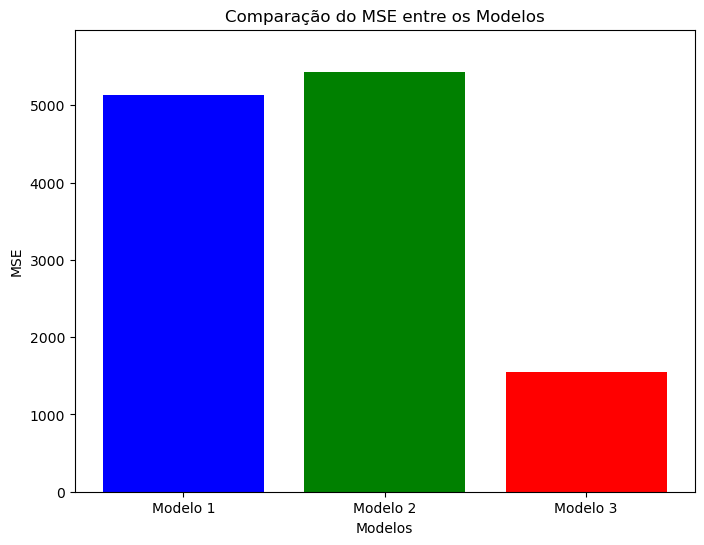

In [43]:
import matplotlib.pyplot as plt

# Supondo que já calculamos os valores de MSE para cada modelo
mse_values = [mse1, mse2, mse3]
model_names = ['Modelo 1', 'Modelo 2', 'Modelo 3']

# Configuração do gráfico
plt.figure(figsize=(8, 6))
plt.bar(model_names, mse_values, color=['blue', 'green', 'red'])
plt.xlabel('Modelos')
plt.ylabel('MSE')
plt.title('Comparação do MSE entre os Modelos')
plt.ylim(0, max(mse_values) * 1.1)  # Ajusta o limite do eixo y para dar um espaço extra
plt.show()
